# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer

# magic word for producing visualizations in notebook
%matplotlib inline


plt.style.use('bmh')

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.

azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv",sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv",sep= ';')

In [3]:
check = azdias

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
feat_info['type'].value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

In [6]:
feat_info.head(2)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"


In [7]:
feat_info['missing_or_unknown'].value_counts()

[-1]        26
[-1,9]      17
[-1,0]      16
[0]         12
[]          10
[-1,X]       1
[-1,0,9]     1
[XX]         1
[-1,XX]      1
Name: missing_or_unknown, dtype: int64

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [8]:
# Identify missing or unknown data values and convert them to NaNs.
azdias.isnull().sum().sum()

## To find out how many columns are Categorical variable and Numeric variables in a Dataframe 
#display(azdias.dtypes.value_counts())

## Seperate the Categorical and Numerical Columns seperately 
#cat_vars = azdias.columns[azdias.dtypes == "object"]
#num_vars = azdias.columns[azdias.dtypes !="object"]

4896838

In [9]:
for indx in range(len(feat_info)):
    missing_or_unknown = feat_info.iloc[indx]['missing_or_unknown']
    missing_or_unknown = missing_or_unknown.strip('[')
    missing_or_unknown = missing_or_unknown.strip(']')
    missing_or_unknown = missing_or_unknown.split(sep=',')
    missing_or_unknown = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_or_unknown]
    if missing_or_unknown != ['']:
        azdias = azdias.replace({feat_info.iloc[indx]['attribute']: missing_or_unknown}, np.nan)

In [10]:
# Identify missing or unknown data values and convert them to NaNs.
azdias.isnull().sum().sum()
#azdias.isnull().sum()

8373929

In [11]:
feat_info.head(2)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"


In [12]:
feat_info['information_level'].value_counts()

person            43
macrocell_plz8     8
building           7
household          7
microcell_rr3      6
region_rr1         5
community          3
microcell_rr4      3
postcode           3
Name: information_level, dtype: int64

In [13]:
feat_info['type'].value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

In [14]:
#for indx in range(len(feat_info)):
    #if (feat_info.iloc[indx]['type'] == 'categorical' or feat_info.iloc[indx]['type'] == 'ordinal' or feat_info.iloc[indx]['type'] == 'mixed' or feat_info.iloc[indx]['type'] == 'interval') :              
        #azdias[feat_info.iloc[indx]['attribute']] = pd.Categorical(azdias[feat_info.iloc[indx]['attribute']])
    #else : 
        #azdias[feat_info.iloc[indx]['attribute']] = pd.to_numeric(azdias[feat_info.iloc[indx]['attribute']])    

In [15]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 205378 non-null float64
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              498903 non-null float64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               780025 non-null float64
LP_LEBENSPHASE_FEIN      793589 non-null float64
LP_LEBENSPHASE_GROB      796649 non-null float64
LP_FAMILIE_FEIN          813429 non-null float64
LP_FAMILIE_GROB          

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [16]:
# Perform an assessment of how much missing data there is in each column of the
# data 
columns = feat_info['attribute']

## Missing Data in each of the columns 
azdias.isnull().sum().sort_values(ascending=False)/len(azdias)

## Removing the Columns where the NA's are more than 30%
del_cols = ['TITEL_KZ','AGER_TYP','KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR','ALTER_HH']

azdias.drop(labels = del_cols,axis=1,inplace = True)

In [17]:
print(len(azdias.columns))

79


In [18]:
### Variable to store the Column Missing 
col_miss = azdias.isnull().sum().sort_values(ascending=True)/len(azdias)

In [19]:
list(set(azdias.dtypes.tolist()))

[dtype('float64'), dtype('int64'), dtype('O')]

In [20]:
# Investigate patterns in the amount of missing data in each column.
num_col = feat_info[feat_info['type'] == "numeric"]['attribute']

In [21]:
num_col = num_col.tolist()

In [22]:
num_col

['GEBURTSJAHR',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'MIN_GEBAEUDEJAHR',
 'KBA13_ANZAHL_PKW']

In [23]:
num_col.remove('GEBURTSJAHR')

In [24]:
azdias_num = azdias[num_col]

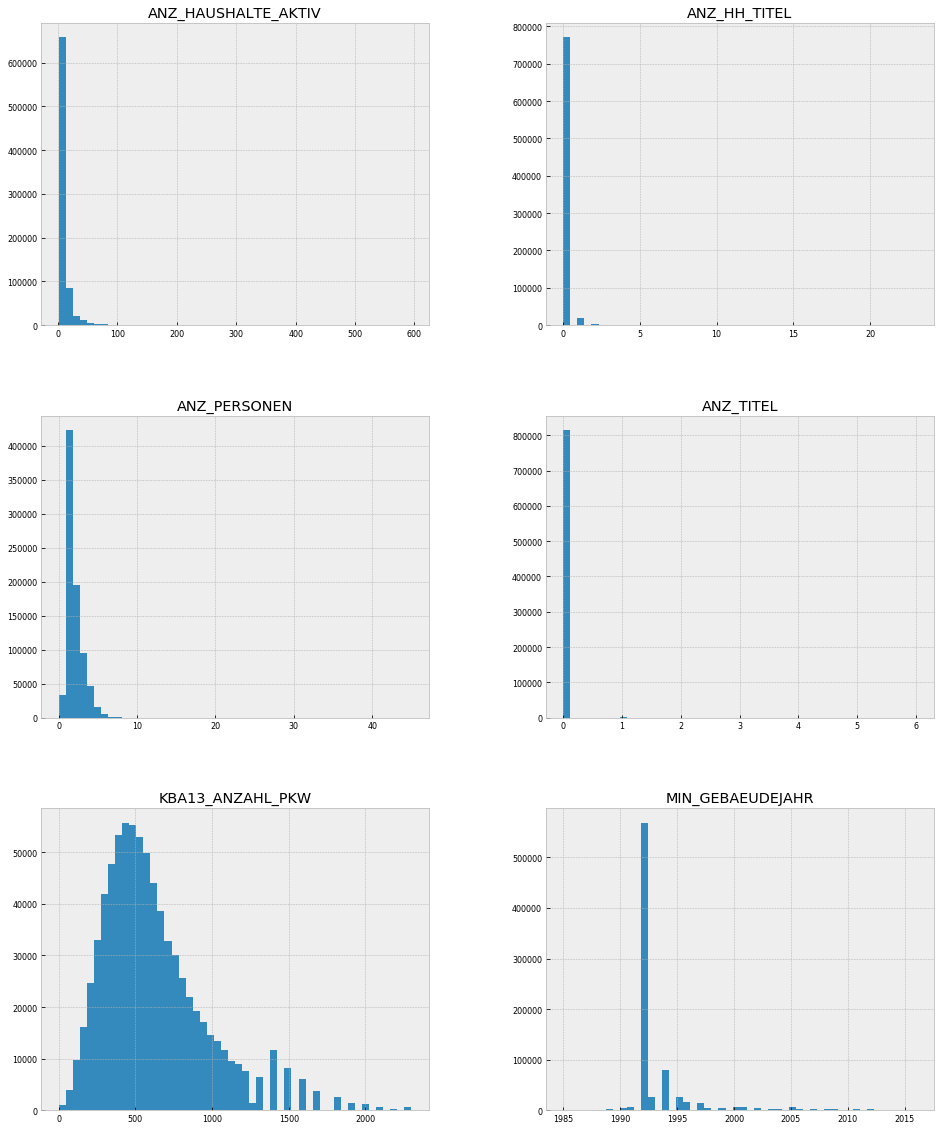

In [25]:
azdias_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8); # ; avoid having the matplotlib verbose informations

In [26]:
azdias_num.describe()

,ANZ_PERSONEN,ANZ_TITEL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,MIN_GEBAEUDEJAHR,KBA13_ANZAHL_PKW
count,817722.000000,817722.000000,791610.000000,794213.000000,798073.000000,785421.000000
mean,1.727637,0.004162,8.354924,0.040647,1993.277011,619.701439
std,1.155849,0.068855,15.673731,0.324028,3.332739,340.034318
min,0.000000,0.000000,1.000000,0.000000,1985.000000,0.000000
25%,1.000000,0.000000,2.000000,0.000000,1992.000000,384.000000
50%,1.000000,0.000000,4.000000,0.000000,1992.000000,549.000000
75%,2.000000,0.000000,10.000000,0.000000,1993.000000,778.000000
max,45.000000,6.000000,595.000000,23.000000,2016.000000,2300.000000


### Columns to delete 

In [27]:
(azdias_num['ANZ_TITEL'] == 0).sum()/len(azdias_num) ### 91% of the values are Zeros - Hence this column has to be removed 

0.91396185682339171

In [28]:
(azdias_num['ANZ_HH_TITEL'] == 0).sum()/len(azdias_num) ### 86% of the values are Zeros - Hence this column has to be removed 

0.86425701369245111

In [29]:
(azdias_num['ANZ_HAUSHALTE_AKTIV'] == 0).sum()/len(azdias_num) ### 86% of the values are Zeros - Hence this column has to be removed 

0.0

In [30]:
del_cols_2 = ['ANZ_TITEL']  ## Both columns ANZ_TITEL and ANZ_HH_TITEL are the same , ANZ_TITEL is deleted becase it has more missing values 

In [31]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

In [32]:
## Plots to detect outliers for an data point 

outliers=[]
def detect_outlier(data_1):
    
    threshold=10
    mean_1 = np.mean(data_1)
    std_1 =np.std(data_1)
    
    
    for y in data_1:
        z_score= (y - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers.append(y)
    return outliers

In [33]:
outlier = detect_outlier(azdias['ANZ_HAUSHALTE_AKTIV'])
print(len(outlier))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in absolute
  del sys.path[0]


1067


#### Outlier Treatmnet for the "ANZ_HAUSHALTE_AKTIV"

18.0


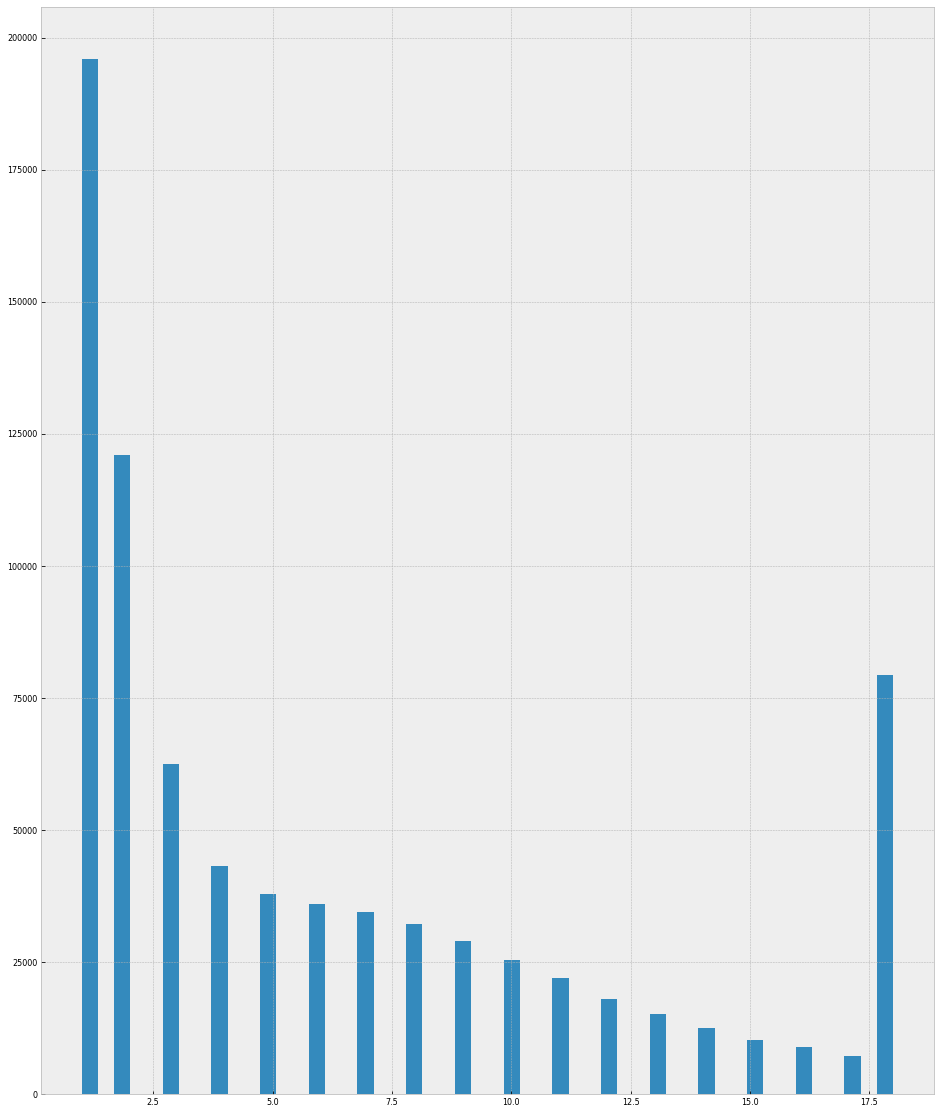

In [34]:
## 90th Percentile of a Column 
print(azdias['ANZ_HAUSHALTE_AKTIV'].quantile(0.90))

## Remove all the outliers greater than 90th percentile by common value 
azdias['ANZ_HAUSHALTE_AKTIV'] = np.where(azdias['ANZ_HAUSHALTE_AKTIV'] >18, 18,azdias['ANZ_HAUSHALTE_AKTIV'])

## Validation of the outlier removal 
azdias['ANZ_HAUSHALTE_AKTIV'].describe()

## Scatter plot 
azdias['ANZ_HAUSHALTE_AKTIV'].hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8); # ; avoid having the matplotlib verbose informations

#### Outlier Treatmnet for the "ANZ_PERSONEN"

3.0


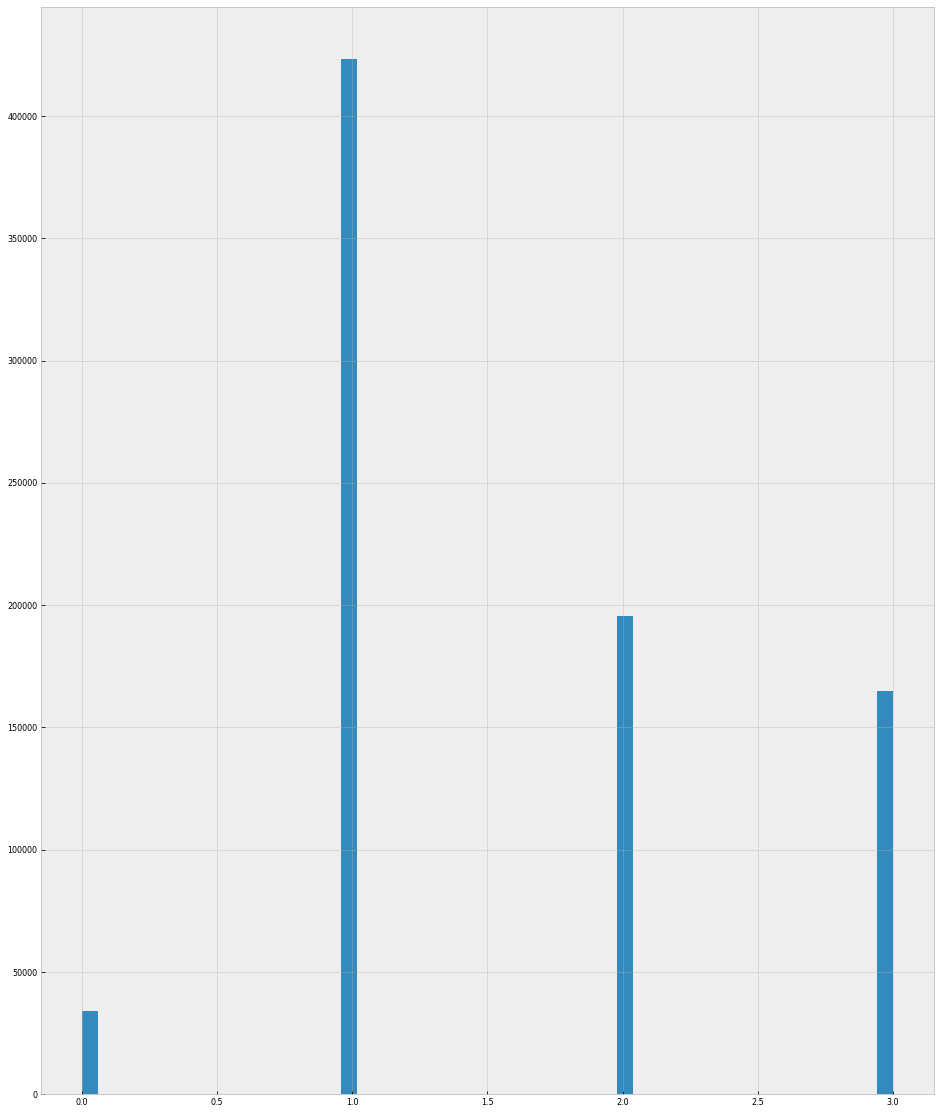

In [35]:
## 90th Percentile of a Column 
print(azdias['ANZ_PERSONEN'].quantile(0.90))

## Remove all the outliers greater than 90th percentile by common value 
azdias['ANZ_PERSONEN'] = np.where(azdias['ANZ_PERSONEN'] >3, 3,azdias['ANZ_PERSONEN'])

## Validation of the outlier removal 
azdias['ANZ_PERSONEN'].describe()

## Scatter plot 
azdias['ANZ_PERSONEN'].hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8); # ; avoid having the matplotlib verbose informations

#### Deleting the 2 Columns  ANZ_TITEL - because most of them are zero's 

In [36]:
azdias.drop(del_cols_2, axis = 1 ,inplace = True)
len(azdias.columns)

78

In [37]:
len(azdias.columns)

78

#### Discussion 1.1.2: Assess Missing Data in Each Column

6 Columns were removed from the dataset , they had missing values more than 35% of the data so it was not possible to impute them hence the 6 Columns were removed. And later 2 other numeric columns (ANZ_TITEL, ANZ_HH_TITEL) had the same data and so ANZ_TITEL of them was removed becuase it had more zeros than the other column. 

Apart from the above , outliers 

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

Prcentage of dat missing in each row of datset:
 643174    62.820513
732775    62.820513
472919    61.538462
183108    58.974359
139316    58.974359
691141    58.974359
691142    58.974359
691171    58.974359
691183    58.974359
139332    58.974359
691197    58.974359
139323    58.974359
691212    58.974359
691122    58.974359
139267    58.974359
139255    58.974359
139250    58.974359
139248    58.974359
139245    58.974359
139243    58.974359
691317    58.974359
691129    58.974359
691118    58.974359
139236    58.974359
139478    58.974359
690871    58.974359
690876    58.974359
690878    58.974359
690887    58.974359
139521    58.974359
            ...    
540246     0.000000
540244     0.000000
540243     0.000000
540242     0.000000
540241     0.000000
540240     0.000000
540239     0.000000
540269     0.000000
540271     0.000000
540300     0.000000
540289     0.000000
540299     0.000000
540298     0.000000
540296     0.000000
540295     0.000000
540293     0.000000
540292     

(array([  6.97109000e+05,   7.76340000e+04,   1.28010000e+04,
          9.53300000e+03,   8.29000000e+02,   1.55000000e+02,
          1.40160000e+04,   5.03100000e+03,   2.85150000e+04,
          4.55980000e+04]),
 array([  0.        ,   6.28205128,  12.56410256,  18.84615385,
         25.12820513,  31.41025641,  37.69230769,  43.97435897,
         50.25641026,  56.53846154,  62.82051282]),
 <a list of 10 Patch objects>)

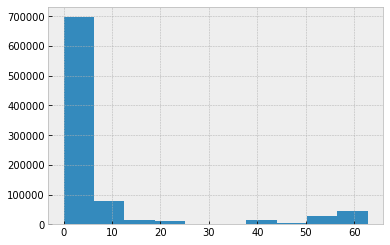

In [38]:
# How much data is missing in each row of the dataset?

row_miss = azdias.isnull().sum(axis=1)/azdias.shape[1]*100
print('Prcentage of dat missing in each row of datset:\n', row_miss.sort_values(ascending=False))

plt.hist(row_miss)

In [39]:
azdias.shape[1]

78

(array([  6.97109000e+05,   7.76340000e+04,   1.28010000e+04,
          9.53300000e+03,   8.29000000e+02,   1.55000000e+02,
          1.40160000e+04,   5.03100000e+03,   2.85150000e+04,
          4.55980000e+04]),
 array([  0.        ,   6.28205128,  12.56410256,  18.84615385,
         25.12820513,  31.41025641,  37.69230769,  43.97435897,
         50.25641026,  56.53846154,  62.82051282]),
 <a list of 10 Patch objects>)

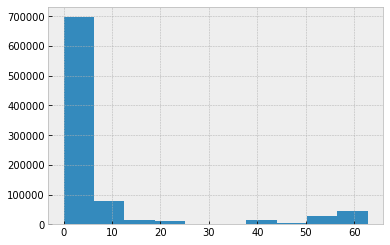

In [40]:
plt.hist(row_miss)

### Sort the Missing Values % row by ascending order to get the right Cut Off 

In [41]:
values = row_miss.value_counts()
df = values.to_frame().reset_index()
df.sort_values(by = 'index', ascending = False)

,index,0
47,62.820513,2
48,61.538462,1
1,58.974359,45578
42,57.692308,17
25,56.410256,536
35,55.128205,117
3,53.846154,27369
28,52.564103,356
32,51.282051,137
37,50.000000,77


###### Based on the data Cut off should be 10% , if the Rows has more than 10% of the Data Set it is grouped into one data frame and if the rows have less than 10% of the Data frame it is grouped into the other data frame 

In [42]:
azdias_less_8 = (azdias[azdias.isnull().sum(axis=1)<=8])  ##### Rows with less than 10%  of thershold missing values 
azdias_grt_8 = (azdias[azdias.isnull().sum(axis=1)>8])  ##### Rows with greater than 10%  of thershold missing values 

In [43]:
azdias_grt_8

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,3.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,2.0,2,4.0,4,3,1,4,5,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,4.0,1.0
24,3.0,2,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,3.0,1,3.0,5,2,4,2,3,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.0,5.0
30,3.0,2,3.0,4,3,4,4,4,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,2.0,2,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,NaN,2,3.0,2,4,3,5,5,4,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
azdias_less_8['SEMIO_REL'].value_counts()

4    193524
3    149486
7    130779
1    101296
5     70970
2     67855
6     57791
Name: SEMIO_REL, dtype: int64

In [45]:
azdias_grt_8['SEMIO_REL'].value_counts()

7    80598
4    13604
5     8596
1     6834
2     5272
6     3301
3     1315
Name: SEMIO_REL, dtype: int64

In [46]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row

In [47]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def comparision_func(df1,df2,column):
    fig,ax = plt.subplots(1,2)
    sns.countplot(df1[column], ax=ax[0])
    sns.countplot(df2[column],ax=ax[1])
    plt.subplots_adjust(wspace=0.5)
    fig.show()
    return


# Identify the 5 columns with the least missing data 

five_columns = col_miss[:5].index.tolist()

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


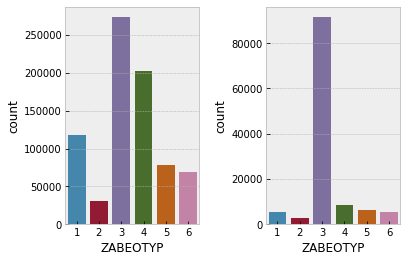

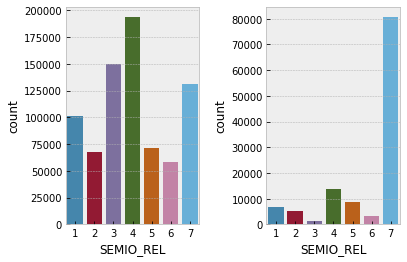

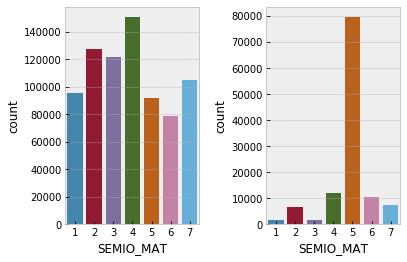

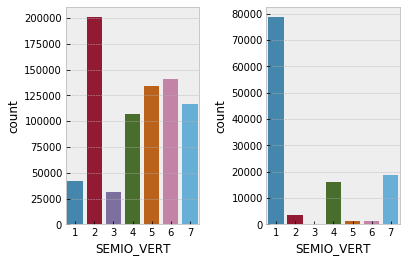

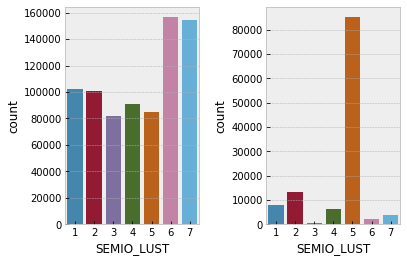

In [48]:
for i in five_columns:
    comparision_func(azdias_less_8,azdias_grt_8,i)

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)


The Missing data points across the rows where varying from 0 to 63% of columns had missing values. After splitting the dataset into 2 different data frames one with the lesser missing values and other data frame with the higher missing value. 

Based on the subset of the 5 columns , we observe that the distributions are different for the 2 data frames , which means we cannot completly ignore the dataset with the higher missing values.  
 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [49]:
# How many features are there of each data type?
feat_info.head(5)


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [50]:
### Need to do the encoding for the 

feat_info['type'].value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

In [51]:
### Check what are the Interval data in the Main Dataframe 
feat_info[feat_info['type'] == "mixed"]

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [52]:
### Interval Column is not availble in the Main Dataframe 
if 'PRAEGENDE_JUGENDJAHRE' in azdias.columns:
    print("Yes Available") 
else : 
    print("Not Available")

Yes Available


In [53]:
azdias['LP_LEBENSPHASE_FEIN'].value_counts()

1.0     62667
5.0     55542
6.0     45614
2.0     39434
8.0     30475
11.0    26710
29.0    26577
7.0     26508
13.0    26085
10.0    25789
31.0    23987
12.0    23300
30.0    22361
15.0    20062
3.0     19985
19.0    19484
37.0    18525
4.0     17595
14.0    17529
20.0    17132
32.0    17105
39.0    16182
40.0    15150
27.0    14475
16.0    14466
38.0    13914
35.0    13679
34.0    13074
9.0     13066
21.0    12766
28.0    12264
24.0    12091
36.0    10505
25.0    10370
23.0     9191
22.0     7224
18.0     7168
33.0     6066
17.0     5888
26.0     3584
Name: LP_LEBENSPHASE_FEIN, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [54]:
## Fetch only Categorical Variables in the Dataset 

Cat_var = feat_info[feat_info['type'] == "categorical"]['attribute']
Cat_var = Cat_var.tolist()

In [55]:
Cat_var.remove('AGER_TYP')
Cat_var.remove('TITEL_KZ')
Cat_var.remove('KK_KUNDENTYP')

In [56]:
Cat_var

['ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [57]:
azdias_Cat = azdias[Cat_var]
azdias_Cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 18 columns):
ANREDE_KZ           891221 non-null int64
CJT_GESAMTTYP       886367 non-null float64
FINANZTYP           891221 non-null int64
GFK_URLAUBERTYP     886367 non-null float64
GREEN_AVANTGARDE    891221 non-null int64
LP_FAMILIE_FEIN     813429 non-null float64
LP_FAMILIE_GROB     813429 non-null float64
LP_STATUS_FEIN      886367 non-null float64
LP_STATUS_GROB      886367 non-null float64
NATIONALITAET_KZ    782906 non-null float64
SHOPPER_TYP         780025 non-null float64
SOHO_KZ             817722 non-null float64
VERS_TYP            780025 non-null float64
ZABEOTYP            891221 non-null int64
GEBAEUDETYP         798073 non-null float64
OST_WEST_KZ         798073 non-null object
CAMEO_DEUG_2015     791869 non-null object
CAMEO_DEU_2015      791869 non-null object
dtypes: float64(11), int64(4), object(3)
memory usage: 122.4+ MB


In [58]:
# Assess categorical variables: which are binary, which are multi-level, and
## To Check the Category Columns which has Binary and Muli level 
for i in azdias_Cat.columns: 
    print(i)
    print(azdias_Cat[i].value_counts())

ANREDE_KZ
2    465305
1    425916
Name: ANREDE_KZ, dtype: int64
CJT_GESAMTTYP
4.0    210963
3.0    156449
6.0    153915
2.0    148795
5.0    117376
1.0     98869
Name: CJT_GESAMTTYP, dtype: int64
FINANZTYP
6    290367
1    199572
4    130625
2    110867
5    106436
3     53354
Name: FINANZTYP, dtype: int64
GFK_URLAUBERTYP
12.0    138545
5.0     120126
10.0    109127
8.0      88042
11.0     79740
4.0      63770
9.0      60614
3.0      56007
1.0      53600
2.0      46702
7.0      42956
6.0      27138
Name: GFK_URLAUBERTYP, dtype: int64
GREEN_AVANTGARDE
0    715996
1    175225
Name: GREEN_AVANTGARDE, dtype: int64
LP_FAMILIE_FEIN
1.0     426379
10.0    137913
2.0     104305
11.0     51719
8.0      23032
7.0      20730
4.0      12303
5.0      11920
9.0      11148
6.0       9022
3.0       4958
Name: LP_FAMILIE_FEIN, dtype: int64
LP_FAMILIE_GROB
1.0    426379
5.0    200780
2.0    104305
4.0     52784
3.0     29181
Name: LP_FAMILIE_GROB, dtype: int64
LP_STATUS_FEIN
1.0     219275
9.0     14323

In [59]:
binary_cols = [x for x in Cat_var if azdias_Cat[x].nunique()==2]
binary_cols

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

In [60]:
azdias_Cat['GEBAEUDETYP'].value_counts()

1.0    460465
3.0    178668
8.0    152476
2.0      4935
4.0       900
6.0       628
5.0         1
Name: GEBAEUDETYP, dtype: int64

#### Columns to Delete 
Column "LP_FAMILIE_GROB" and "LP_FAMILIE_FEIN" have the same information but in the condensed form , hence the Columns "LP_FAMILIE_FEIN" will be 
deleted from the main dataset 

Column "LP_STATUS_GROB" and "LP_STATUS_FEIN" have the same information but in the condensed form , hence the Columns "LP_FAMILIE_FEIN" will be 
 deleted from the main dataset 

Column "CAMEO_DEUG_2015" and "CAMEO_DEU_2015" have the same information but in the condensed form , hence the Columns "LP_FAMILIE_FEIN" will be 
deleted from the main dataset 

In [61]:
#cat_del = ['CAMEO_DEU_2015','LP_STATUS_GROB','CAMEO_DEU_2015']
### Removing 3 Columns whihc are not required for the One Hot Encoding 

Cat_var.remove("LP_FAMILIE_FEIN")
Cat_var.remove("LP_STATUS_FEIN")
Cat_var.remove("CAMEO_DEU_2015")

In [62]:
Cat_var

['ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_GROB',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015']

##### findings from the above 
Columns "GREEN_AVANTGARDE" and "SHOPPER_TYP" are binary columns , they are kept as it 
and Column "OST_WEST_KZ" is non numeric binary column hence we are supposed to do encoding for this  

In [63]:
azdias_less_8['OST_WEST_KZ'] = azdias_less_8['OST_WEST_KZ'].replace({'O':0.0, 'W':1.0})

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [64]:
### Removing the 5 Binary Variables which are not required for the One Hot Encoding 

Cat_var.remove("GREEN_AVANTGARDE")
Cat_var.remove("ANREDE_KZ")
Cat_var.remove("SOHO_KZ")
Cat_var.remove("VERS_TYP")
Cat_var.remove("OST_WEST_KZ")

### Removing the 3 Variables which are not required for the , because they are the duplicates 

Col_del = ['LP_FAMILIE_FEIN','LP_STATUS_FEIN','CAMEO_DEU_2015']
azdias_less_8.drop(Col_del,axis=1,inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [65]:

# which one needs to be re-encoded?

def one_hot_encode(data,list_columns,drop_original_columns=True):    
    #Reset index
    data=data.reset_index(drop=True)
    for current_column in list_columns:
        #print("One Hot Encoding : "+current_column+"\n"+"nunique : "+str(data[current_column].nunique()))
        #display(data.groupby(current_column).size().sort_values(ascending=False))
        
        current_data=pd.get_dummies(data[current_column])
        current_data=current_data.add_prefix(current_column+'_')
        #Merging
        data=pd.merge(data,current_data,left_index=True,right_index=True)
        #print("----------------------------------------")
    #deleting raw columns
    if(drop_original_columns):
        data=data.drop(list_columns,axis=1)
    
    #Returning data frame
    return(data)



In [66]:
azdias_less_8.shape

(771701, 75)

In [67]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias_df=one_hot_encode(azdias_less_8,Cat_var,drop_original_columns=True)

In [68]:
azdias_df.shape

(771701, 128)

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?) 

I have deleted 3 Category columns which are LP_FAMILIE_FEIN ,  LP_STATUS_FEIN and CAMEO_DEU_2015 , because their rough scalte information of these columns were already available in a different column. Hence i have deleted these 3 columns. 

Also there is variable OST_WEST_KZ whihc had Non Numeric variable , it was passed to the dummy variable funtion to encode 

After performing the One Hot Encoding , post which the number of variables increased from 77 to 132. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [69]:
## Fetch only Categorical Variables in the Dataset 
Mix_var = feat_info[feat_info['type'] == "mixed"]['attribute']
Mix_var = Mix_var.tolist()

In [70]:
Mix_var

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'KBA05_BAUMAX',
 'PLZ8_BAUMAX']

In [71]:
azdias['LP_LEBENSPHASE_FEIN'].isnull().sum()

97632

In [72]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

In [73]:
def movement(x):
    if x in (2,4,6,7,9,11,13,15):
        return 0 
    if x in (1,3,5,8,10,12,14):
        return 1 
    elif pd.isna(x):
        return x

In [74]:
def decade(x):
    if x in (1,2):
        return 1 
    elif x in (3,4):
        return 2
    elif x in (5,6,7):
        return 3
    elif x in (8,9):
        return 4
    elif x in (10,11,12,13):
        return 5
    elif x in (14,15):
        return 6   
    elif pd.isna(x):
        return x

In [75]:
azdias_df['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = azdias_df['PRAEGENDE_JUGENDJAHRE'].apply(movement)

In [76]:
azdias_df['PRAEGENDE_JUGENDJAHRE_DECADE'] = azdias_df['PRAEGENDE_JUGENDJAHRE'].apply(decade)

In [77]:
### Quick check to ensure there is no additional flow of NA's after re  engineering the Data frame

print(azdias_df['PRAEGENDE_JUGENDJAHRE'].isnull().sum())
print(azdias_df['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].isnull().sum())
print(azdias_df['PRAEGENDE_JUGENDJAHRE_DECADE'].isnull().sum())

24329
24329
24329


In [78]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_df['WEALTH'] = azdias_df['CAMEO_INTL_2015'] 
azdias_df['LIFE_STAGE'] = azdias_df['CAMEO_INTL_2015']

In [79]:
life_stage_dict = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5, '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5, '51':1, '52':2, '53':3, '54':4, '55':5}
wealth_dict = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2, '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4, '51':5, '52':5, '53':5, '54':5, '55':5}

In [80]:
azdias_df['WEALTH'].replace(wealth_dict, inplace=True) 
azdias_df['LIFE_STAGE'].replace(life_stage_dict, inplace=True)

In [81]:
## Quick check to ensure no additional flow of NA's into the Data 
print(azdias_df['CAMEO_INTL_2015'].isnull().sum())
print(azdias_df['WEALTH'].isnull().sum())
print(azdias_df['LIFE_STAGE'].isnull().sum())

3339
3339
3339


In [82]:
### Check what are the Interval data in the Main Dataframe 


In [83]:
## Delete the 3 columns from the Data table which was re engineered 
### LP_LEBENSPHASE_FEIN Column to be deleted 

    
mix_drop = ['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015','LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB']
azdias_df.drop(mix_drop,axis=1,inplace=True)

In [84]:
## The only Interval variable was ALTER_HH House hold that has been also removed in the previous data cleaning process 

if 'GEBAEUDETYP_5.0' in azdias_df.columns:
    print("Yes Available") 
else : 
    print("Not Available")

Yes Available


In [85]:
## This specific column has only one row , so ths column is being deleted  
azdias_df.drop('GEBAEUDETYP_5.0',axis=1,inplace=True)

In [86]:
azdias_df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_DECADE,WEALTH,LIFE_STAGE
0,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,1,0,1.0,6.0,5.0,1.0
1,3.0,2,1,4,1,2,3,5,1,3.0,...,1,0,0,0,0,0,0.0,6.0,2.0,4.0
2,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0,1.0,4.0,1.0,2.0
3,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,1,0,0,0,1.0,4.0,4.0,3.0
4,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,0,1,0,1.0,2.0,5.0,4.0


#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)  

Columns Deleted : 
LP_LEBENSPHASE_GROB - Column has the same information of the Family type, fine scale which is already present in the 
the column "LP_LEBENSPHASE_FEIN"  and "LP_FAMILIE_FEIN" ---- hence this Column will be deleted  

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [87]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [88]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



In [89]:
#check.info()

In [90]:
#check.info()

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [91]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep =';' )
    
    # convert missing value codes into NaNs, ...

    for indx in range(len(feat_info)):
        missing_or_unknown = feat_info.iloc[indx]['missing_or_unknown']
        missing_or_unknown = missing_or_unknown.strip('[')
        missing_or_unknown = missing_or_unknown.strip(']')
        missing_or_unknown = missing_or_unknown.split(sep=',')
        missing_or_unknown = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_or_unknown]
        if missing_or_unknown != ['']:
            df = df.replace({feat_info.iloc[indx]['attribute']: missing_or_unknown}, np.nan )    
    
    # remove selected columns and rows, ...
    
    outlier_cols = ['AGER_TYP','GEBURTSJAHR','TITEL_KZ','ALTER_HH','KK_KUNDENTYP','KBA05_BAUMAX','ANZ_TITEL','LP_FAMILIE_FEIN','LP_STATUS_FEIN','CAMEO_DEU_2015']
    df_new = df.drop(outlier_cols,axis=1)
    df_clean = df_new[df_new.isnull().sum(axis=1) < 30]
                            
    categorical = feat_info[feat_info['type'] == 'categorical']['attribute'].values
    categorical_features = feat_info[feat_info['type'] == 'categorical']['attribute'].values
    categorical_features = [x for x in categorical_features if x in df_clean.columns]
    binary_cols = [x for x in categorical_features if df_clean[x].nunique()==2]
    multilevel = [x for x in categorical_features if df_clean[x].nunique()>2] 
                       
    df_clean['OST_WEST_KZ'] = df_clean['OST_WEST_KZ'].replace({'O':0.0, 'W':1.0})                      
 
    ## Removing the columns which are not required   
    #multilevel.remove("LP_FAMILIE_FEIN")
    #multilevel.remove("LP_STATUS_FEIN")
    #multilevel.remove("CAMEO_DEU_2015")
    
    ## Dummy encoding 
    
    # Re-encode categorical variable(s) to be kept in the analysis.
    df_encoded=one_hot_encode(df_clean,multilevel,drop_original_columns=True)

    ## Removing the columns which will be dummy coded                          
    #df_encoded = df_clean.drop(multilevel, axis =1)                      
                            
    # select, re-encode, and engineer column values.
    
    def movement(x):
        if x in (2,4,6,7,9,11,13,15):
            return 0 
        if x in (1,3,5,8,10,12,14):
            return 1 
        elif pd.isna(x):
            return x
        
    def decade(x):
        if x in (1,2):
            return 1 
        elif x in (3,4):
            return 2
        elif x in (5,6,7):
            return 3
        elif x in (8,9):
            return 4
        elif x in (10,11,12,13):
            return 5
        elif x in (14,15):
            return 6   
        elif pd.isna(x):
            return x    
        
    df_encoded['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = df_encoded['PRAEGENDE_JUGENDJAHRE'].apply(movement)
    df_encoded['PRAEGENDE_JUGENDJAHRE_DECADE'] = df_encoded['PRAEGENDE_JUGENDJAHRE'].apply(decade)
    
    df_encoded['WEALTH'] = df_encoded['CAMEO_INTL_2015'] 
    df_encoded['LIFE_STAGE'] = df_encoded['CAMEO_INTL_2015']
    
    life_stage_dict = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5, '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5, '51':1, '52':2, '53':3, '54':4, '55':5}
    wealth_dict = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2, '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4, '51':5, '52':5, '53':5, '54':5, '55':5}                     
                        
    df_encoded['WEALTH'].replace(wealth_dict, inplace=True) 
    df_encoded['LIFE_STAGE'].replace(life_stage_dict, inplace=True)
    
    df_clean = df_encoded.drop(['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015','LP_LEBENSPHASE_GROB','LP_LEBENSPHASE_FEIN'], axis =1)                        
                            
    # Return the cleaned dataframe.
    
    return df_clean
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [92]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

azd_cleaned = azdias_df

In [93]:
azd_cleaned.dropna(inplace=True)

In [94]:
azd_cleaned.shape ### 19% of the Data is lost bcoz of NA , but its fine we would have the other rows to contribute to the Variance 

(623211, 127)

In [95]:
# Apply feature scaling to the general population demographics data.

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [96]:
azdias_scaled = scaler.fit_transform(azd_cleaned)

In [97]:
azdias_scaled= pd.DataFrame(azdias_scaled, columns= azd_cleaned.columns)

In [98]:
azdias_scaled[:5]

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_DECADE,WEALTH,LIFE_STAGE
0,-1.746287,0.977825,-1.512226,1.581061,-1.045045,1.539061,1.047076,1.340485,-0.553672,1.044646,...,-0.383816,-0.265612,-0.403042,-0.331589,2.114437,-0.403596,0.553672,1.164455,1.147884,-1.251111
1,0.202108,0.977825,-1.512226,0.900446,-1.765054,-0.531624,0.318375,1.340485,1.806125,1.044646,...,2.605416,-0.265612,-0.403042,-0.331589,-0.472939,-0.403596,-1.806125,1.164455,-0.909992,0.749820
2,0.202108,-1.022678,0.692400,0.219832,0.394972,-1.221852,0.318375,-0.856544,-0.553672,1.044646,...,-0.383816,-0.265612,2.481134,-0.331589,-0.472939,-0.403596,0.553672,-0.213395,0.461926,0.082843
3,-1.746287,0.977825,-0.042475,-1.141397,1.114980,-0.531624,-0.410325,1.340485,-0.553672,1.044646,...,-0.383816,-0.265612,-0.403042,-0.331589,2.114437,-0.403596,0.553672,-1.591245,1.147884,0.749820
4,-0.772089,0.977825,-1.512226,1.581061,-1.765054,1.539061,1.047076,-0.124201,-0.553672,-0.273495,...,2.605416,-0.265612,-0.403042,-0.331589,-0.472939,-0.403596,0.553672,0.475530,-0.909992,-0.584134


In [99]:
# Apply feature scaling to the general population demographics data.


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [100]:
# Apply PCA to the data.

def do_pca(n_components, data):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.
    
    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform
           
    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
    X = StandardScaler().fit_transform(data)
    pca = PCA(n_components)
    X_pca = pca.fit_transform(X)
    return pca, X_pca

In [101]:
## Function to get the necessary thersold 
#for x in range(20,60):
   # pca, X_pca = do_pca(x,azdias_scaled)
   # if pca.explained_variance_ratio_.sum() >= 0.85: 
      #  break

In [102]:
#X_pca.shape

In [103]:
pca, X_pca = do_pca(50, azdias_scaled)

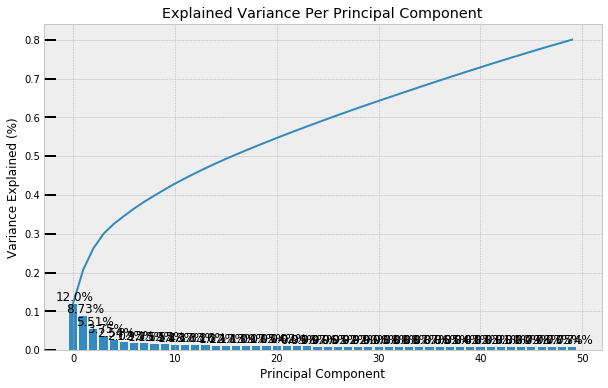

In [104]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    

scree_plot(pca)


In [105]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca=PCA(20)
X_pca = pca.fit_transform(azdias_scaled)

In [106]:
pca.explained_variance_ratio_.sum()

0.53408647332402814

In [107]:
X_pca.shape

(623211, 20)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

Initially PCA analysis was started by doing 50 variables and than plotted the Princpal Componenet vs Variance Explained chart. 
In the figure it was found out that the only after 50 variables , General population of the data was able to reach a Cumalative Variance of 80% and finally 

Each of the bars represents the amount of variability explained by each component.  So you can see the first component explains 11.7% of the variability in the General population data.The second explains 8.35% of the variability and so on. Often the number of components is chosen based on the total amount of variability explained by the components. You can see that by using 50 components, we capture almost 80% of the total variability in the data.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [108]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

components = pca.components_
components

array([[-0.11410116,  0.00514938, -0.19747304, ...,  0.10076824,
         0.17748552, -0.11309419],
       [ 0.22869839,  0.05632659,  0.05913395, ..., -0.22927445,
         0.07550152, -0.00944201],
       [ 0.0401277 , -0.34840528,  0.13775044, ..., -0.07153269,
         0.01685593, -0.01142991],
       ..., 
       [-0.05027409,  0.0070584 , -0.03813693, ..., -0.01761037,
         0.06346594, -0.00096476],
       [-0.03934752,  0.00592961,  0.00367987, ..., -0.00388883,
        -0.00076942, -0.09744755],
       [-0.10585815,  0.04624299,  0.05816401, ..., -0.02495555,
         0.08265941, -0.09166959]])

In [109]:
comp_20 = pd.DataFrame(pca.components_,columns=azdias_scaled.columns)

In [110]:
comp_20

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_DECADE,WEALTH,LIFE_STAGE
0,-0.114101,0.005149,-0.197473,0.136329,-0.108958,0.070995,0.073257,0.134686,-0.106382,0.033137,...,-0.072044,-0.012074,-0.002563,0.030884,0.088417,0.110439,0.106382,0.100768,0.177486,-0.113094
1,0.228698,0.056327,0.059134,-0.212214,0.207149,-0.189699,-0.208810,0.107659,-0.021884,-0.046249,...,-0.043855,-0.006258,0.010403,0.011925,0.048882,0.029275,0.021884,-0.229274,0.075502,-0.009442
2,0.040128,-0.348405,0.137750,-0.069127,0.065132,-0.162950,-0.058418,-0.055479,0.067411,-0.006057,...,-0.024763,0.000752,-0.005368,-0.000727,0.010955,0.020143,-0.067411,-0.071533,0.016856,-0.011430
3,-0.031131,0.076440,0.020531,0.004473,-0.019596,-0.090125,0.079101,-0.054961,0.319940,-0.008889,...,-0.037059,0.028045,-0.034416,-0.015616,-0.028763,-0.029692,-0.319940,0.035909,-0.098570,0.047685
4,0.043128,-0.019103,0.072009,-0.012942,-0.001270,0.060406,-0.108845,-0.075882,-0.059486,0.018645,...,0.004153,-0.029084,-0.005504,-0.007603,0.043443,0.057423,0.059486,0.013528,0.081565,-0.039140
5,0.028896,0.015235,-0.050801,0.005027,-0.014935,0.027961,-0.022430,0.061284,-0.024748,-0.042309,...,0.006441,0.059538,-0.041505,0.010924,-0.043146,0.001508,0.024748,0.005351,-0.046127,-0.007900
6,-0.032099,0.015441,0.099342,-0.001333,-0.116102,0.024910,-0.056965,-0.119033,0.061409,0.076299,...,-0.011520,0.026395,-0.063460,-0.020139,-0.045217,0.026907,-0.061409,0.038240,-0.069053,0.023598
7,-0.001461,0.056008,-0.157266,0.058035,-0.050167,0.078924,0.103747,0.253395,0.067212,-0.293408,...,-0.029878,-0.005535,0.043246,-0.028323,0.037549,-0.063125,-0.067212,-0.005103,-0.012471,0.101635
8,-0.056941,0.057707,0.015120,-0.107284,0.078151,-0.064045,-0.151717,0.109688,-0.022747,-0.104625,...,-0.065097,0.048943,0.080455,0.018410,0.062996,-0.085006,0.022747,-0.102096,0.056579,0.042549
9,-0.074102,0.047892,0.019703,-0.062799,0.122248,-0.086193,0.010830,0.038309,-0.041478,-0.083817,...,0.053344,-0.046132,-0.087956,-0.041495,-0.061742,0.081561,0.041478,-0.102446,-0.071062,-0.006450


In [111]:
len(pca.components_[0])

127

In [112]:
def pca_dims(data,pca):
    ''' Dataframe with PCA Restuls'''
    
    # Dimension Indexing 
    dimensions = dimensions = ['Dimenson{}'.format(i) for i in range(1,len(pca.components_)+1)]
    
    # PCA Componenets 
    components = pd.DataFrame(np.round(pca.components_,4),columns=data.keys())
    components.index=dimensions 
    
    # PCA Explained Variance 
    ratios = pca.explained_variance_.reshape(len(pca.components_),1)
    variance_ratios = pd.DataFrame(np.round(ratios,4), columns=['Explained Variance'])
    variance_ratios.index = dimensions
    
    # Return a Concataned Data Frame 
    return pd.concat([variance_ratios,components],axis=1)
    

In [113]:
pca_dims(azdias_scaled,pca)

,Explained Variance,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_DECADE,WEALTH,LIFE_STAGE
Dimenson1,14.9165,-0.1141,0.0051,-0.1975,0.1363,-0.1090,0.0710,0.0733,0.1347,-0.1064,...,-0.0720,-0.0121,-0.0026,0.0309,0.0884,0.1104,0.1064,0.1008,0.1775,-0.1131
Dimenson2,10.8290,0.2287,0.0563,0.0591,-0.2122,0.2071,-0.1897,-0.2088,0.1077,-0.0219,...,-0.0439,-0.0063,0.0104,0.0119,0.0489,0.0293,0.0219,-0.2293,0.0755,-0.0094
Dimenson3,6.8404,0.0401,-0.3484,0.1378,-0.0691,0.0651,-0.1630,-0.0584,-0.0555,0.0674,...,-0.0248,0.0008,-0.0054,-0.0007,0.0110,0.0201,-0.0674,-0.0715,0.0169,-0.0114
Dimenson4,4.6553,-0.0311,0.0764,0.0205,0.0045,-0.0196,-0.0901,0.0791,-0.0550,0.3199,...,-0.0371,0.0280,-0.0344,-0.0156,-0.0288,-0.0297,-0.3199,0.0359,-0.0986,0.0477
Dimenson5,3.1551,0.0431,-0.0191,0.0720,-0.0129,-0.0013,0.0604,-0.1088,-0.0759,-0.0595,...,0.0042,-0.0291,-0.0055,-0.0076,0.0434,0.0574,0.0595,0.0135,0.0816,-0.0391
Dimenson6,2.5076,0.0289,0.0152,-0.0508,0.0050,-0.0149,0.0280,-0.0224,0.0613,-0.0247,...,0.0064,0.0595,-0.0415,0.0109,-0.0431,0.0015,0.0247,0.0054,-0.0461,-0.0079
Dimenson7,2.3984,-0.0321,0.0154,0.0993,-0.0013,-0.1161,0.0249,-0.0570,-0.1190,0.0614,...,-0.0115,0.0264,-0.0635,-0.0201,-0.0452,0.0269,-0.0614,0.0382,-0.0691,0.0236
Dimenson8,2.1734,-0.0015,0.0560,-0.1573,0.0580,-0.0502,0.0789,0.1037,0.2534,0.0672,...,-0.0299,-0.0055,0.0432,-0.0283,0.0375,-0.0631,-0.0672,-0.0051,-0.0125,0.1016
Dimenson9,1.9774,-0.0569,0.0577,0.0151,-0.1073,0.0782,-0.0640,-0.1517,0.1097,-0.0227,...,-0.0651,0.0489,0.0805,0.0184,0.0630,-0.0850,0.0227,-0.1021,0.0566,0.0425
Dimenson10,1.9221,-0.0741,0.0479,0.0197,-0.0628,0.1222,-0.0862,0.0108,0.0383,-0.0415,...,0.0533,-0.0461,-0.0880,-0.0415,-0.0617,0.0816,0.0415,-0.1024,-0.0711,-0.0065


In [114]:
def pca_results(full_dataset, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
    #PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions
    
    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions
    
    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (15,10))
    
    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)
    
    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.03, "Explained Variance\n          %.4f"%(ev))
    

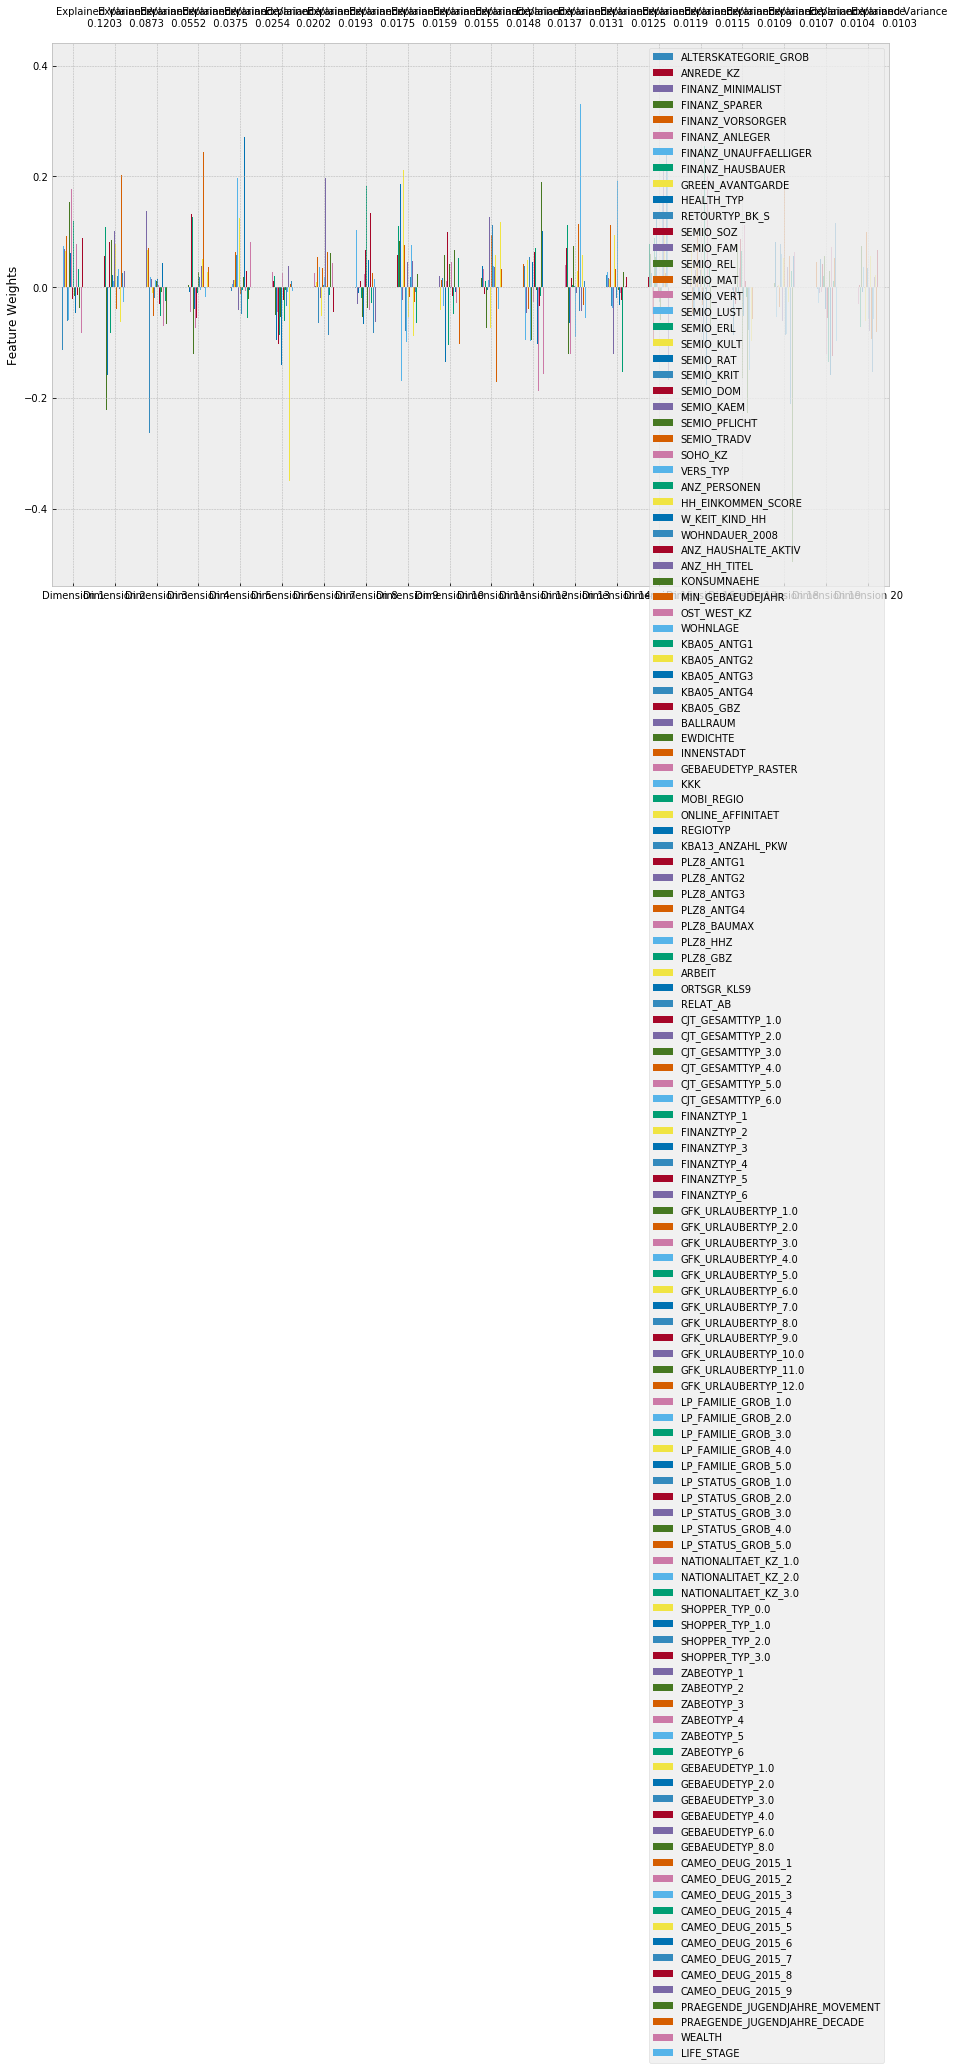

In [115]:
pca_results(azdias_scaled,pca)

In [116]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.


In [117]:
def weights(Pcomp,data):
         comp = pd.DataFrame(pca.components_,columns=data.columns)
         weights_comp_top_5 = comp.iloc[Pcomp].sort_values(ascending=False).head(5)
         weights_comp_bot_5 = comp.iloc[Pcomp].sort_values(ascending=False).tail(5)
         return weights_comp_top_5, weights_comp_bot_5

In [118]:
weights(0,azdias_scaled)

(ANZ_HAUSHALTE_AKTIV    0.195414
 LP_STATUS_GROB_1.0     0.191632
 PLZ8_ANTG3             0.184215
 PLZ8_ANTG4             0.180230
 HH_EINKOMMEN_SCORE     0.177712
 Name: 0, dtype: float64, KBA05_GBZ           -0.183643
 PLZ8_ANTG1          -0.186158
 KBA05_ANTG1         -0.193458
 FINANZ_MINIMALIST   -0.197473
 MOBI_REGIO          -0.206361
 Name: 0, dtype: float64)

### Explantion of the First Componenet 

#### Main Features of the First Princpal Component : It focuses on the The first component component seems to capture the population density, and  financial affluence of the person


#### Positive Features - People with Dense and lower Income 
ANZ_HAUSHALTE_AKTIV - # of Households in a building 
LP_STATUS_GROB_1.0 - # Low Income Earners  
PLZ8_ANTG3 - # of 6-10 family houses in the PLZ8 region
PLZ8_ANTG4 - # of 10+ Family memebers in the house 
HH_EINKOMMEN_SCORE - # Estimate Households income 



#### Negative Features - People with less Dense and higher finance 
KBA05_GBZ - # of Buildings in a Microceel 
PLZ8_ANTG1 - # of 1-2 family houses in the PLZ8 region
KBA05_ANTG1 - # of 1-2 family houses in the microcell
FINANZ_MINIMALIST - low financial interest
MOBI_REGIO - Movement patterns


In [119]:
weights(1,azdias_scaled)

(ALTERSKATEGORIE_GROB    0.228698
 FINANZ_VORSORGER        0.207149
 ZABEOTYP_3              0.202597
 SEMIO_ERL               0.191590
 SEMIO_LUST              0.158077
 Name: 1, dtype: float64, FINANZ_UNAUFFAELLIGER          -0.208810
 SEMIO_PFLICHT                  -0.209395
 FINANZ_SPARER                  -0.212214
 SEMIO_REL                      -0.222803
 PRAEGENDE_JUGENDJAHRE_DECADE   -0.229274
 Name: 1, dtype: float64)

#### Main Features of the Second Princpal Component : The second component component seems to capture the age , financial type and certain behaviours of the People  


#### Positive Features - Older People with Financial preperation 
ALTERSKATEGORIE_GROB - # Age of People  
FINANZ_VORSORGER - Finance be prepared - Lower Financially prepared 
ZABEOTYP_3 - Energy Consumption ... fair supplied - Lower Event oriented 
SEMIO_ERL - Personality event-oriented - 
SEMIO_LUST - Personality sensual-minded



#### Negative Features - Younger generation , with lower money saving and less religious 
FINANZ_UNAUFFAELLIGER - Finance inconspicuous
SEMIO_PFLICHT - Personality dutiful
FINANZ_SPARER - money-saver
SEMIO_REL - Personallity religious
PRAEGENDE_JUGENDJAHRE -Person's Age 

In [120]:
if 'PRAEGENDE_JUGENDJAHRE' in azdias_scaled.columns:
    print("Yes Available") 
else : 
    print("Not Available")

Not Available


In [121]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

weights(2,azdias_scaled)

(SEMIO_VERT     0.327204
 SEMIO_SOZ      0.256608
 SEMIO_FAM      0.255207
 SEMIO_KULT     0.239210
 FINANZTYP_5    0.142629
 Name: 2, dtype: float64, SEMIO_ERL    -0.191528
 SEMIO_KRIT   -0.263604
 SEMIO_DOM    -0.290681
 SEMIO_KAEM   -0.321244
 ANREDE_KZ    -0.348405
 Name: 2, dtype: float64)

### Explantion of the Third Componenet 

#### Main Features of the Third Princpal Component : It focuses on the The third component component seems to capture the gender and behaviour personality 


#### Positive Features - Less Dreamful , Socially minded and less cultured People 
SEMIO_VERT - Personality Type Dreamful (1 Highest - 9 Lowest) - Less Dreamful 
SEMIO_SOZ - Personality socially-minded  (1 Highest - 9 Lowest) - Less Social Minded
SEMIO_FAM - Personality family-minded (1 Highest - 9 Lowest) - Less Family Minded 
SEMIO_KULT - Personality cultural-minded  (1 Highest - 9 Lowest) - Less Cultural 
FINANZTYP_5 -  financial type for individual - Investor 



#### Negative Features - Less Event oriented , less dominant and Less critical minded 
SEMIO_ERL - Personality  event-oriented (1 Highest - 9 Lowest) - Less Event Oriented 
SEMIO_KRIT- Personality critical-minded (1 Highest - 9 Lowest) - Less Critical Minded 
SEMIO_DOM - Personality dominant-minded (1 Highest - 9 Lowest) - Less Dominant
SEMIO_KAEM - Personality combative attitude - Less Combativie 
ANREDE_KZ - Gender 


### Discussion 2.3: Interpret Principal Components



## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [122]:
# Over a number of different cluster counts...
from sklearn.cluster import KMeans

def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

    # run k-means clustering on the data and...

# compute the average within-cluster distances.

In [123]:
scores = []
centers = list(range(2,15))    
    
for center in centers:
    scores.append(get_kmeans_score(X_pca,center))

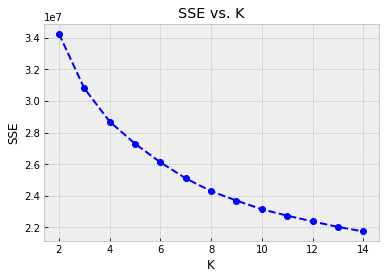

In [124]:
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K'); 

In [125]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

In [126]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans= KMeans(8)
model = kmeans.fit(X_pca)
azdias_pred = model.predict(X_pca)

In [127]:
# 10 Clusters and 20 Componenets 
kmeans.cluster_centers_.shape

(8, 20)

In [128]:
#azdias_pred
np.bincount(azdias_pred)

array([106024,  91523,  66888,  92288,  87709,  55262,  57645,  65872])

In [129]:
azdias_ratio = (np.bincount(azdias_pred)/len(azdias_pred))*100

In [130]:
azdias_pred

array([7, 2, 3, ..., 7, 6, 3], dtype=int32)

In [131]:
X_pca

array([[ 4.6683303 , -2.87081108, -3.06338614, ..., -1.28890389,
         1.4412475 ,  0.18043692],
       [-0.42285697, -0.79274015, -3.53741444, ..., -0.35334199,
        -1.11023328, -1.35655314],
       [-0.11911567,  0.12521882,  2.96962355, ..., -0.19780369,
        -1.73256915,  0.07397255],
       ..., 
       [ 4.50439067, -2.81473448, -3.46073509, ...,  1.095555  ,
        -0.21246137, -1.39106454],
       [ 6.65403892, -3.47735702,  2.55984458, ..., -1.50702712,
         1.8699371 , -0.12803484],
       [-0.05080712,  2.06014114,  2.1241915 , ..., -1.51273279,
        -1.95028741, -1.6627455 ]])

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [132]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep =';')

In [133]:
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


#### Data cleaning 

In [134]:
cust = clean_data(customers)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [135]:
customers.isnull().sum().sum()

2252274

In [136]:
cust.isnull().sum().sum()

107199

In [137]:
cust.shape

(141725, 127)

In [138]:
cust.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_DECADE,WEALTH,LIFE_STAGE
0,4.0,1,5,1,5,1,2,2,1,1.0,...,0,0,0,0,0,0,0.0,2.0,1.0,3.0
1,4.0,2,5,1,5,1,4,4,1,2.0,...,0,1,0,0,0,0,0.0,2.0,3.0,4.0
2,4.0,1,5,1,5,2,1,2,0,2.0,...,1,0,0,0,0,0,1.0,1.0,2.0,4.0
3,3.0,1,3,1,4,4,5,2,0,3.0,...,0,0,0,1,0,0,1.0,4.0,4.0,1.0
4,3.0,1,5,1,5,1,2,3,1,3.0,...,0,1,0,0,0,0,0.0,2.0,3.0,4.0


In [139]:
cust.shape

(141725, 127)

In [140]:
azdias_df.shape

(623211, 127)

In [141]:
## Check the # of Columns matching with the General Population and the Customer Base 
azdias_df.columns.difference(cust.columns).tolist()
len(cust.columns) == len(azdias_df.columns)

True

In [142]:
cust_cleaned = cust

In [143]:
len(cust_cleaned)

141725

In [144]:
cust_cleaned.dtypes.unique()

array([dtype('float64'), dtype('int64'), dtype('uint8')], dtype=object)

In [145]:
## Create 2 data frames for Categorical and Numeric Columns , 
## Numeric columns will be treated for Imputation missing values 
cust_num = cust_cleaned.select_dtypes(exclude ='uint8')
cust_cat = cust_cleaned.select_dtypes(include ='uint8')

In [146]:
cust_num.shape

(141725, 65)

In [147]:
cust_cat.shape

(141725, 62)

##### Data Transformation 

In [148]:
imputer = Imputer(strategy = 'mean')

In [149]:
## Treat the Missing values in the Numeric Column with the Mean 
cust_num = pd.DataFrame(imputer.fit_transform(cust_num), columns = cust_num.columns)

In [150]:
## Merge the 2 data frames before and after Join 
cust_clean = pd.merge(cust_num, cust_cat, left_index=True, right_index=True)

In [151]:
cust_clean.isnull().sum().sum()

0

In [152]:
cust.shape

(141725, 127)

In [153]:
cust_clean.shape

(141725, 127)

In [154]:
scal = StandardScaler()
cust_scaled =scal.fit_transform(cust_clean)

In [155]:
cust_scaled = pd.DataFrame(cust_scaled, columns = cust_clean.columns)

In [156]:
cust_scaled.shape

(141725, 127)

#### Dimensionality Reduction 

In [157]:
## No of Components for PCA is 20 
cust_pca = pca.fit_transform(cust_scaled)

In [158]:
cust_pca.shape

(141725, 20)

In [159]:
df_cust_pca = pd.DataFrame(cust_pca, columns=np.arange(1, 21))
df_cust_pca

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,-3.755249,-3.715539,0.389337,-0.649221,-1.295861,3.442022,-1.095753,-1.599102,-0.397334,0.101658,-0.094639,1.191378,0.343020,0.191021,-2.277426,0.356388,-0.431428,-0.621910,-0.654205,0.403957
1,3.535762,-2.288930,-3.003782,2.894275,-0.912321,-0.377242,-0.860207,0.760686,-0.715999,0.196547,-0.332720,-3.758058,0.190739,0.960195,0.822386,0.526925,1.167252,-0.417952,-1.631877,0.529682
2,-3.233916,-0.224124,-1.212894,-4.773212,-1.423790,0.057771,0.237675,1.162138,0.823123,-0.400636,-1.265976,-1.137824,0.189614,1.972406,1.997021,-1.789579,2.467482,0.069079,0.916937,-1.392817
3,2.974645,4.605200,2.459863,-1.515980,1.258651,-0.332513,1.383938,-1.484547,-1.059016,-0.337072,1.022616,-3.405928,0.237908,-0.866079,-0.934092,0.181336,0.108752,0.411930,-0.824830,2.707226
4,-0.172278,-0.675484,2.437733,2.063484,-1.910401,-0.783132,1.279746,-2.148191,0.290528,-2.111542,-0.461187,-0.822086,-1.856673,0.612589,-1.717932,1.203394,-0.848983,-0.050934,1.380620,0.302011
5,-4.422999,-1.970306,-0.125457,-0.980758,-1.961982,0.376577,0.163015,-1.664570,1.441835,0.760097,-0.941081,0.412589,1.107627,0.297330,-2.133911,0.800064,1.248827,-0.221161,-0.951975,-1.198432
6,-2.394311,-4.411558,1.948782,0.938919,-0.671599,1.452422,-1.872714,1.485986,-1.438817,-0.082648,0.124893,0.848060,0.227139,0.312665,-1.457922,1.956143,-0.439143,0.312574,0.479891,-0.022999
7,10.385274,-2.113288,-1.878191,-0.127371,-0.616210,4.284928,1.092658,1.903285,5.604418,-1.438702,2.765183,0.186829,1.048790,-1.269872,2.382213,0.834934,-0.217915,0.283396,0.243252,-0.438974
8,-3.950140,1.796431,2.090001,2.262855,0.578883,-0.556531,-0.130578,-1.973852,2.145441,-0.794851,-0.459464,-0.019849,-0.061461,-0.310276,0.176457,-0.232024,0.993000,0.985233,-1.798399,-0.015753
9,-4.249835,-1.493179,2.176032,-0.300197,-2.446297,1.870092,-1.112375,1.844320,0.051964,0.875474,-0.890247,-0.849854,2.044936,-0.583719,-0.252655,-0.886588,-1.144698,-0.403404,-1.246946,-0.690945


#### Clustering 

In [160]:
model = kmeans.fit(cust_pca)
cust_cls_pred = model.predict(cust_pca)

In [161]:
np.unique(cust_cls_pred)

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32)

In [162]:
cust_ratio = np.bincount(cust_cls_pred)/len(cust_cls_pred)*100

In [163]:
cust_ratio

array([ 16.92361969,  19.21467631,  10.06456165,   3.58511201,
        16.54965602,  12.1206562 ,   9.19597813,  12.34573999])

In [164]:
cust_cls_pred

array([1, 0, 4, ..., 1, 0, 4], dtype=int32)

In [165]:
np.unique(cust_cls_pred)

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Text(0,0.5,'Proportion of People %')

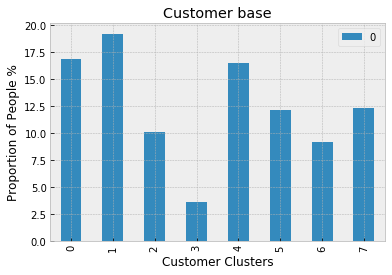

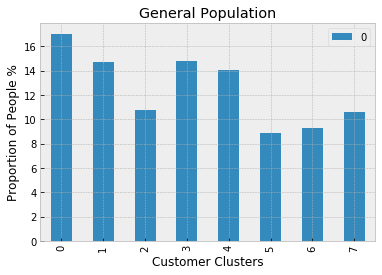

In [166]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

from matplotlib import pyplot as plt

plotdata = pd.DataFrame(cust_ratio)
plotdata.plot(kind="bar",title="Customer base")
plt.xlabel("Customer Clusters")
plt.ylabel("Proportion of People %")


plotdata_2 = pd.DataFrame(azdias_ratio)
plotdata_2.plot(kind="bar",title ="General Population")
plt.xlabel("Customer Clusters")
plt.ylabel("Proportion of People %")

In [167]:
azdias_ratio

array([ 17.01253669,  14.68571639,  10.73280157,  14.80846776,
        14.07372463,   8.86730176,   9.24967627,  10.56977492])

In [168]:
cust_ratio

array([ 16.92361969,  19.21467631,  10.06456165,   3.58511201,
        16.54965602,  12.1206562 ,   9.19597813,  12.34573999])

In [169]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

### Cluster 1 and Cluster 5 are clearly overrepresented from the Customer base to the General Population 

In [170]:
# Add cluster labels
df_cust_pca['cluster'] = cust_cls_pred

In [171]:
#g = sns.pairplot(df_cust_pca,
#                 vars = np.arange(1, 21), 
#                 diag_kind = 'kde',
#                 hue="cluster",
#                 palette="Paired");

In [172]:
# Rename components for better reading
df_cust_pca = df_cust_pca.rename(columns = {1: 'pop_density-finance_status',
                                            2: 'age-generation',
                                            3: 'gender'}
                                )

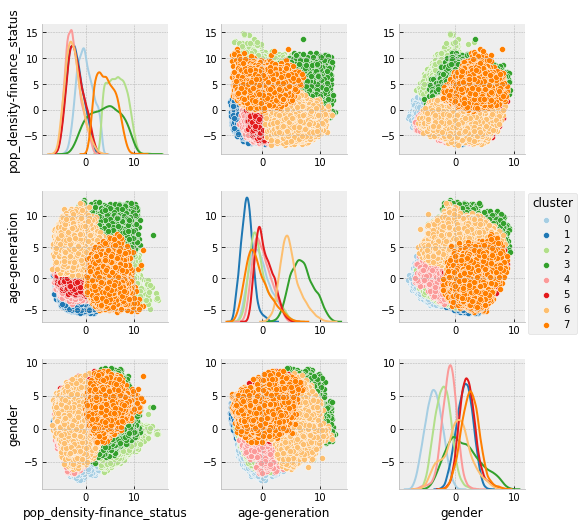

In [173]:
g = sns.pairplot(df_cust_pca,
                 vars = ['pop_density-finance_status', 'age-generation', 'gender'],
                 diag_kind = 'kde',
                 hue="cluster",
                 palette="Paired");

#### Observations

Cluster No 1 (thick blue) seems to be 
    - corelated to lower values of the 1st component (Population Density - Financial status) and 
    - corealted to lower values of the 2nd component (Age, Generation and Culture) and 
    - Values are centred around zero (Gender and their main corresponding personality types)
    
Cluster No 3 (thick green) seems to be the 
    - corelated to the  higher values of the first component, 
    - corealted to the higher values of the 2nd component (Age, Generation and Culture) and 
    - ditributed equally between higher and lower values for the 3rd principal component(Gender and their main corresponding personality)

In [183]:
def map_kmeans_weights_to_feats(kmeans, df, clust_no):
    '''Map pca weights to  individual features
    and return two pd.Series on with the highest
    positive weights and one with the lowest negative
    weights'''

    weights = pd.DataFrame(np.round(kmeans.cluster_centers_, 4), columns=df.keys())
    centroid = weights.iloc[clust_no, :]
    cent_pos = centroid[centroid > 0].sort_values(ascending=False)
    cent_neg = centroid[centroid < 0].sort_values(ascending=True)

    return cent_pos, cent_neg

#### What kinds of people are part of a cluster that is overrepresented in the customer data compared to the general population?

In [185]:
# Overrepresented 
over_pos, over_neg = map_kmeans_weights_to_feats(kmeans, df_cust_pca.iloc[:, :-1], 1)
over_pos, over_neg

(gender    1.6172
 6         0.5690
 4         0.4864
 10        0.3636
 5         0.3340
 19        0.1815
 12        0.1756
 14        0.1624
 13        0.1518
 9         0.0487
 8         0.0245
 Name: 1, dtype: float64, age-generation               -2.6690
 pop_density-finance_status   -2.1472
 7                            -0.6857
 20                           -0.1531
 18                           -0.1469
 11                           -0.0718
 16                           -0.0691
 15                           -0.0572
 17                           -0.0275
 Name: 1, dtype: float64)


Looking at the centroid distances table with the highly negative value for pop_density-finance_status and the strongly positive value for gender, confirms the pairplot observations and strengthens the assumption that the overrepresented group are: Men that are less dreamful, less socially-minded, less cultural-minded,types, that have a higher financial status and live in less densely populated areas. 

The negative weight for the age-generation principal component in conjunction with the attitude characteristics of these men suggests that they could be of relative younger age.

#### What kinds of people are part of a cluster that is underepresented in the customer data compared to the general population?

In [187]:
# Underrepresented 
over_pos, over_neg = map_kmeans_weights_to_feats(kmeans, df_cust_pca.iloc[:, :-1], 3)
over_pos, over_neg

(age-generation                6.8761
 pop_density-finance_status    3.9562
 10                            2.6552
 6                             1.5341
 gender                        1.4887
 18                            1.0223
 4                             0.8890
 19                            0.7794
 20                            0.1314
 8                             0.0404
 17                            0.0364
 12                            0.0117
 Name: 3, dtype: float64, 7    -1.7954
 11   -0.5901
 15   -0.5391
 14   -0.5193
 5    -0.5005
 16   -0.2715
 13   -0.1311
 9    -0.0997
 Name: 3, dtype: float64)

Highly positive value for pop_density-finance_status and for Age-generation and along with slight positive weight for the gender principal component confirms the pairplot observations and strengthens the assumption that the underrepresented group are:  

Younger women that are less dominant-minded, less critical-minded, have a less combative attitude and are less prone to investing and live in densely populated areas with a lower financial status. They have lower religious affinity, lower money saving culture and are less traditional minded.

### Discussion 3.3: Compare Customer Data to Demographics Data


Yes based on the above clusters , Company can focus more the Overrepresented Cluster , because the response rate would be higher than the other average response rate. 

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.